In [9]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Load the dataset
file_path = '/Users/rajeevmaharaj/Desktop/risk/RISK_Port.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
data.head()

### Step 1: System Design - Analyzing Distributions

# Analyze distributions for key columns
columns_to_analyze = [
    'Personal consumption expenditures: Food (Billion)',
    'US Retail Sales by (billion)',
    'US GDP (trillion)',
    'S&P 500 Food Products Industry Index(close)',
    'CPI'
]



In [1]:
pwd

'/Users/rajeevmaharaj/Desktop/risk'

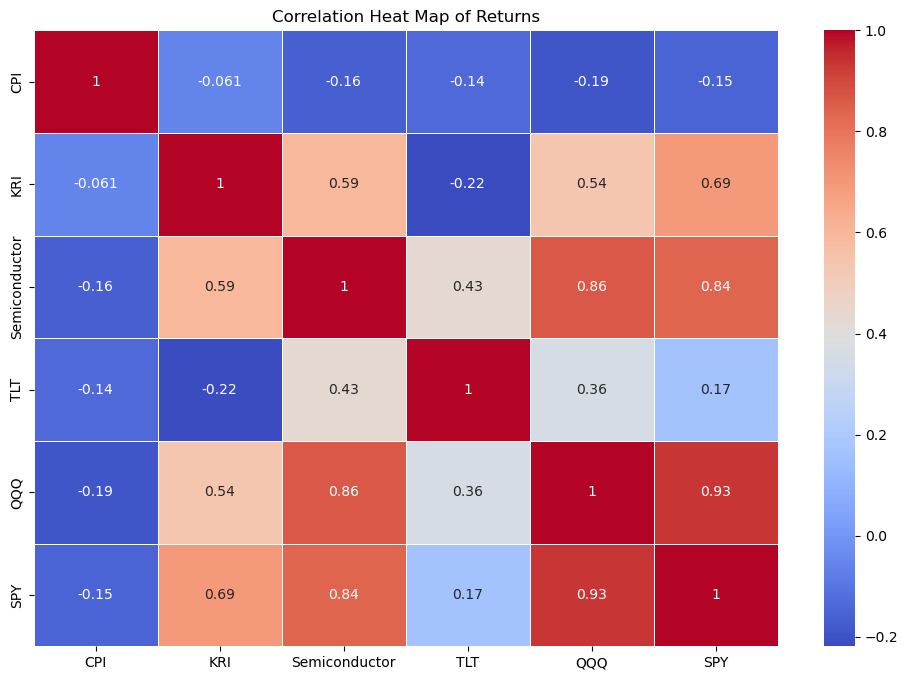

In [17]:
#Convert the 'Date(quarter)' column to datetime format
data['Date'] = pd.to_datetime(data['Date(quarter)'], format='%d-%b-%y')

# Filter data to start from 2010
data = data[data['Date'] >= '2010-01-01']

# Sort data by date in ascending order
data = data.sort_values(by='Date').reset_index(drop=True)

# Fill missing values using forward fill method
data = data.fillna(method='ffill').fillna(method='bfill')

# List of tickers
tickers = ['CPI', 'KRI', 'Semiconductor', 'TLT', 'QQQ', 'SPY']

# Calculate the percentage change (returns) for each ticker
returns = data[tickers].pct_change()

# Calculate the correlation matrix
correlation_matrix = returns.corr()

# Create a heat map
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heat Map of Returns')
plt.show()

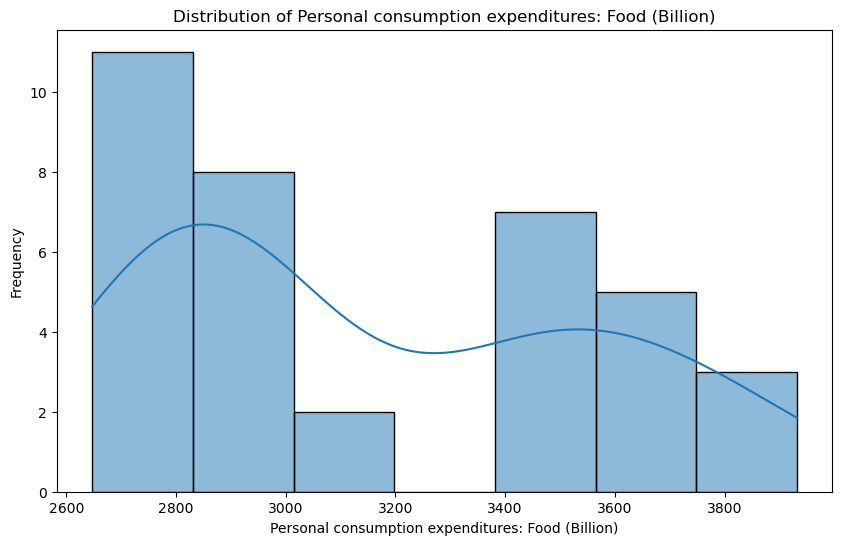

Skewness of Personal consumption expenditures: Food (Billion): 0.46620420990208494



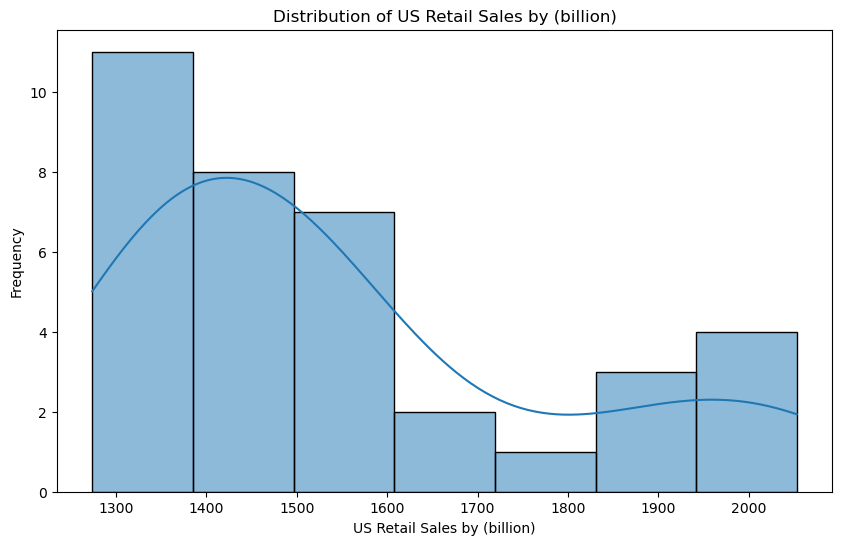

Skewness of US Retail Sales by (billion): 1.03573033794846



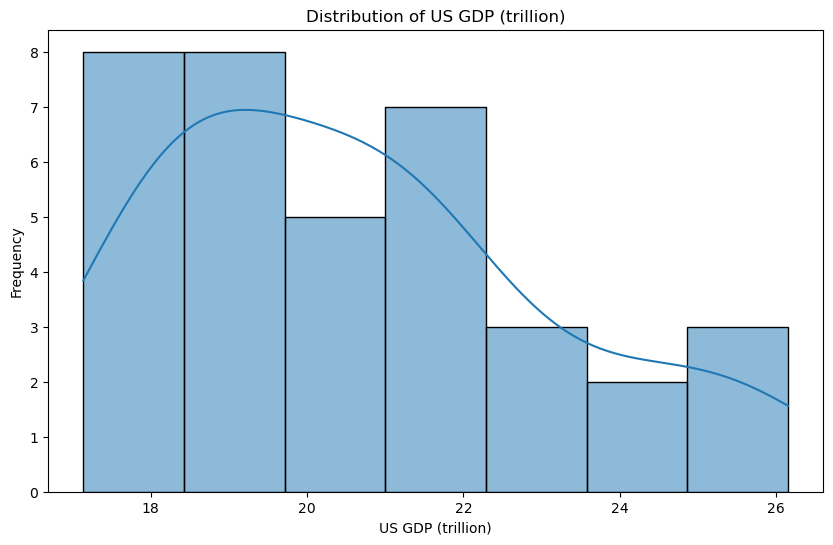

Skewness of US GDP (trillion): 0.7006960670344714



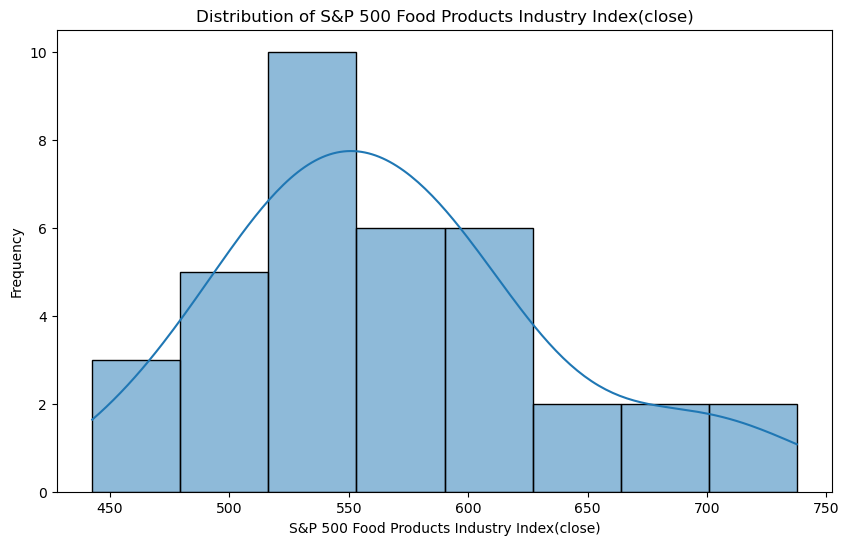

Skewness of S&P 500 Food Products Industry Index(close): 0.6484727776485372



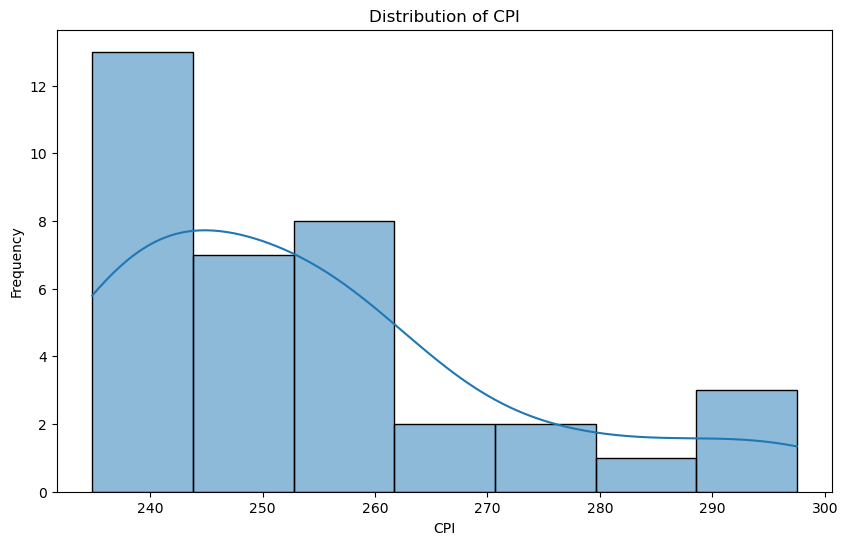

Skewness of CPI: 1.121908605488411



In [10]:
# Calculate skewness and plot distributions
for column in columns_to_analyze:
    skewness = data[column].skew()
    plt.figure(figsize=(10, 6))
    sns.histplot(data[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()
    print(f"Skewness of {column}: {skewness}\n")




In [18]:
### Step 2: Regression Model

# Prepare regression model data
X = data[[
    'Personal consumption expenditures: Food (Billion)',
    'US Retail Sales by (billion)',
    'US GDP (trillion)',
    'CPI',
    'KRI',
    'Semiconductor',
    'TLT',
    'QQQ',
    'SPY'
]]
y = data['S&P 500 Food Products Industry Index(close)']

In [19]:
# Fit the model
regression_model = LinearRegression()
regression_model.fit(X, y)

# Display the coefficients
coefficients = regression_model.coef_
intercept = regression_model.intercept_

print("Regression Coefficients:", coefficients)
print("Intercept:", intercept)

### Step 3: Forward Returns

# Calculate forward returns
data['Forward_1'] = data['S&P 500 Food Products Industry Index(close)'].shift(-1) / data['S&P 500 Food Products Industry Index(close)'] - 1
data['Forward_2'] = data['S&P 500 Food Products Industry Index(close)'].shift(-2) / data['S&P 500 Food Products Industry Index(close)'] - 1
data['Forward_3'] = data['S&P 500 Food Products Industry Index(close)'].shift(-3) / data['S&P 500 Food Products Industry Index(close)'] - 1


Regression Coefficients: [ 1.40085873e-02  1.21066938e-01 -3.73951658e+01  4.74031988e+00
 -4.07279625e+00  2.48008536e+00 -3.68747614e+00  1.90405277e+00
 -2.31900366e+00]
Intercept: 697.7875525796169


In [20]:
# Display average forward returns
forward_returns = data[['Forward_1', 'Forward_2', 'Forward_3']].mean()
print("Average Forward Returns:")
print(forward_returns)

Average Forward Returns:
Forward_1    0.015669
Forward_2    0.028184
Forward_3    0.042410
dtype: float64


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_30028/3602765280.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Signal'][data['SMA_3'] > data['SMA_6']] = 1
/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_30028/3602765280.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Signal'][data['SMA_3'] < data['SMA_6']] = -1


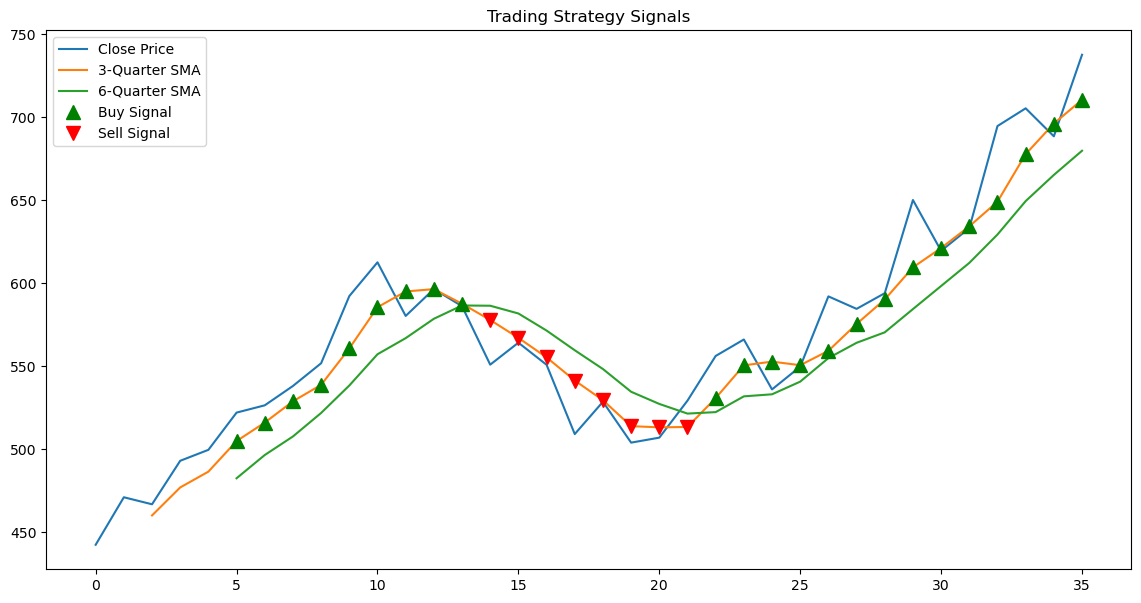

In [21]:
### Step 4: Trading Strategy

# Calculate moving averages
data['SMA_3'] = data['S&P 500 Food Products Industry Index(close)'].rolling(window=3).mean()
data['SMA_6'] = data['S&P 500 Food Products Industry Index(close)'].rolling(window=6).mean()

# Implementing trading strategy based on moving average crossovers
data['Signal'] = 0
data['Signal'][data['SMA_3'] > data['SMA_6']] = 1
data['Signal'][data['SMA_3'] < data['SMA_6']] = -1
data['Position'] = data['Signal'].shift(1)

# Calculate strategy returns
data['Strategy_Returns'] = data['Position'] * data['S&P 500 Food Products Industry Index(close)'].pct_change()

# Plot signals
plt.figure(figsize=(14, 7))
plt.plot(data['S&P 500 Food Products Industry Index(close)'], label='Close Price')
plt.plot(data['SMA_3'], label='3-Quarter SMA')
plt.plot(data['SMA_6'], label='6-Quarter SMA')
plt.plot(data[data['Signal'] == 1].index, data['SMA_3'][data['Signal'] == 1], '^', markersize=10, color='g', label='Buy Signal')
plt.plot(data[data['Signal'] == -1].index, data['SMA_3'][data['Signal'] == -1], 'v', markersize=10, color='r', label='Sell Signal')
plt.title('Trading Strategy Signals')
plt.legend()
plt.show()


In [22]:

### Step 5: Trade Signals Analysis

# Analyze trade signals
buy_signals = len(data[data['Signal'] == 1])
sell_signals = len(data[data['Signal'] == -1])

print(f"Number of Buy Signals: {buy_signals}")
print(f"Number of Sell Signals: {sell_signals}")

Number of Buy Signals: 23
Number of Sell Signals: 8


Final Investment Value: -10155


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_30028/1547806914.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Investment'].iloc[i] = data['Investment'].iloc[i-1]
/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_30028/1547806914.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Investment'].iloc[i] = data['Investment'].iloc[i-1] - (trade_amount + commission)
/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_30028/1547806914.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

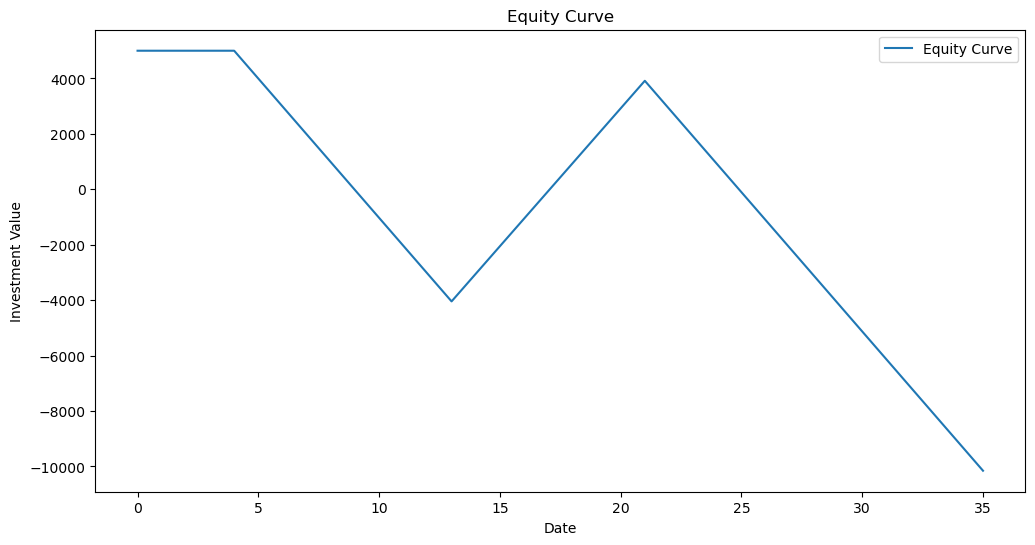

'\n# Improvement Suggestions\n1. **Longer Time Frames**: Use longer time frames for moving averages to reduce noise and frequent transactions.\n2. **Additional Indicators**: Incorporate other technical indicators like RSI, MACD, etc., to improve signal accuracy.\n3. **Risk Management**: Implement stop-loss and take-profit levels to manage risk better.\n4. **Diversification**: Apply the strategy to a diversified portfolio instead of a single index to reduce specific risks.\n5. **Machine Learning Models**: Explore advanced machine learning models to predict index movements and generate signals.\n'

In [23]:
### Step 6: Quantify The Cost

# Initial investment and trade cost calculation
initial_investment = 5000
trade_amount = 1000
commission = 5

data['Investment'] = initial_investment
for i in range(1, len(data)):
    if data['Signal'].iloc[i] == 1:
        data['Investment'].iloc[i] = data['Investment'].iloc[i-1] - (trade_amount + commission)
    elif data['Signal'].iloc[i] == -1:
        data['Investment'].iloc[i] = data['Investment'].iloc[i-1] + (trade_amount - commission)
    else:
        data['Investment'].iloc[i] = data['Investment'].iloc[i-1]

# Final investment value
final_investment = data['Investment'].iloc[-1]
print(f"Final Investment Value: {final_investment}")

### Step 7: Performance Metric

# Plot the equity curve
plt.figure(figsize=(12, 6))
plt.plot(data['Investment'], label='Equity Curve')
plt.title('Equity Curve')
plt.xlabel('Date')
plt.ylabel('Investment Value')
plt.legend()
plt.show()

### Step 8: Improvement

"""
# Improvement Suggestions
1. **Longer Time Frames**: Use longer time frames for moving averages to reduce noise and frequent transactions.
2. **Additional Indicators**: Incorporate other technical indicators like RSI, MACD, etc., to improve signal accuracy.
3. **Risk Management**: Implement stop-loss and take-profit levels to manage risk better.
4. **Diversification**: Apply the strategy to a diversified portfolio instead of a single index to reduce specific risks.
5. **Machine Learning Models**: Explore advanced machine learning models to predict index movements and generate signals.
"""

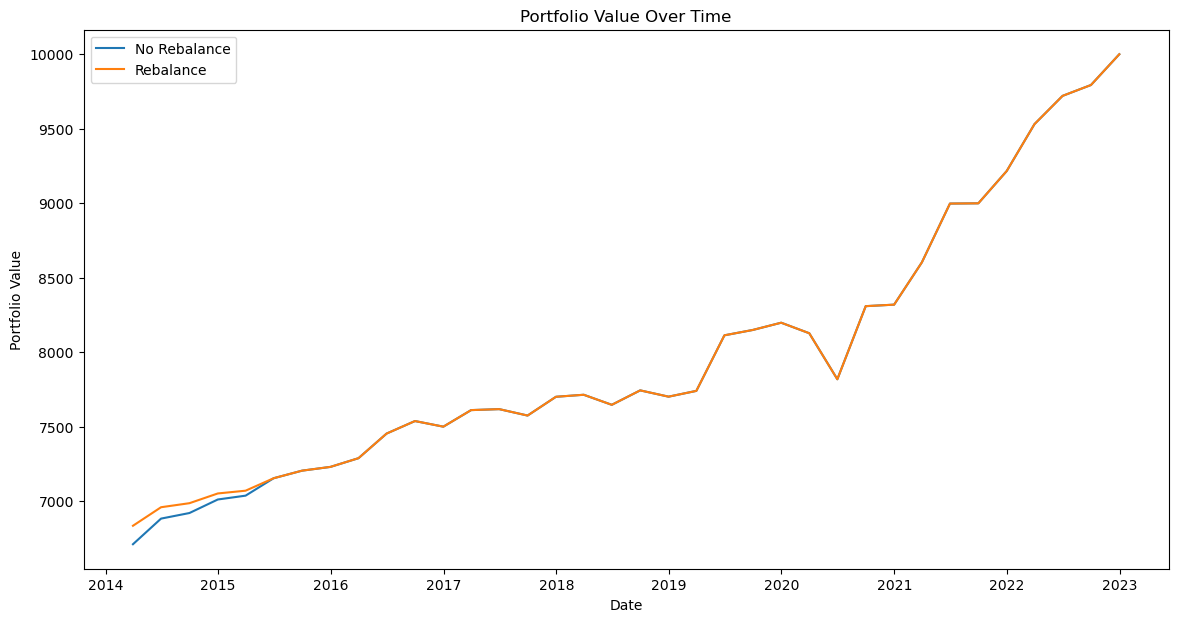

Final Return Without Rebalancing: -32.88%
Final Return With Rebalancing: -31.64%


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/Users/rajeevmaharaj/Desktop/risk/RISK_Port.csv'
data = pd.read_csv(file_path, parse_dates=['Date(quarter)'])
data.set_index('Date(quarter)', inplace=True)

# Convert columns to numeric values
for column in data.columns:
    if data[column].dtype == 'object':
        data[column] = pd.to_numeric(data[column].str.replace(',', '').str.replace('%', ''), errors='coerce')

# Fill NaN values if necessary
data = data.fillna(method='ffill').fillna(method='bfill')

# Ensure that the columns match the initial weights
columns_to_use = [
    'Personal consumption expenditures: Food (Billion)',
    'US Retail Sales by (billion)',
    'US GDP (trillion)',
    'S&P 500 Food Products Industry Index(close)',
    'CPI'
]
data = data[columns_to_use]

# Define initial portfolio weights
initial_weights = {
    'Personal consumption expenditures: Food (Billion)': 0.2,
    'US Retail Sales by (billion)': 0.2,
    'US GDP (trillion)': 0.2,
    'S&P 500 Food Products Industry Index(close)': 0.2,
    'CPI': 0.2
}

# Calculate daily returns for the assets
returns = data.pct_change()

# Calculate portfolio value without rebalancing
initial_investment = 10000
portfolio_value_no_rebalance = [initial_investment]
weights_no_rebalance = list(initial_weights.values())

for i in range(1, len(returns)):
    portfolio_return = np.dot(returns.iloc[i], weights_no_rebalance)
    new_value = portfolio_value_no_rebalance[-1] * (1 + portfolio_return)
    portfolio_value_no_rebalance.append(new_value)

# Calculate portfolio value with rebalancing every 30 days
portfolio_value_rebalance = [initial_investment]
weights_rebalance = list(initial_weights.values())
rebalance_period = 30

for i in range(1, len(returns)):
    portfolio_return = np.dot(returns.iloc[i], weights_rebalance)
    new_value = portfolio_value_rebalance[-1] * (1 + portfolio_return)
    portfolio_value_rebalance.append(new_value)
    
    # Rebalance every 30 days
    if i % rebalance_period == 0:
        total_value = portfolio_value_rebalance[-1]
        weights_rebalance = [(total_value / initial_investment) * w for w in list(initial_weights.values())]

# Ensure the lengths match
portfolio_value_no_rebalance = portfolio_value_no_rebalance[:len(returns)]
portfolio_value_rebalance = portfolio_value_rebalance[:len(returns)]

# Create a DataFrame for portfolio values
portfolio_values = pd.DataFrame({
    'No Rebalance': portfolio_value_no_rebalance,
    'Rebalance': portfolio_value_rebalance
}, index=returns.index)

# Plot the portfolio values
plt.figure(figsize=(14, 7))
plt.plot(portfolio_values['No Rebalance'], label='No Rebalance')
plt.plot(portfolio_values['Rebalance'], label='Rebalance')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

# Calculate and compare the final returns
final_return_no_rebalance = portfolio_value_no_rebalance[-1] / initial_investment - 1
final_return_rebalance = portfolio_value_rebalance[-1] / initial_investment - 1

print(f"Final Return Without Rebalancing: {final_return_no_rebalance:.2%}")
print(f"Final Return With Rebalancing: {final_return_rebalance:.2%}")


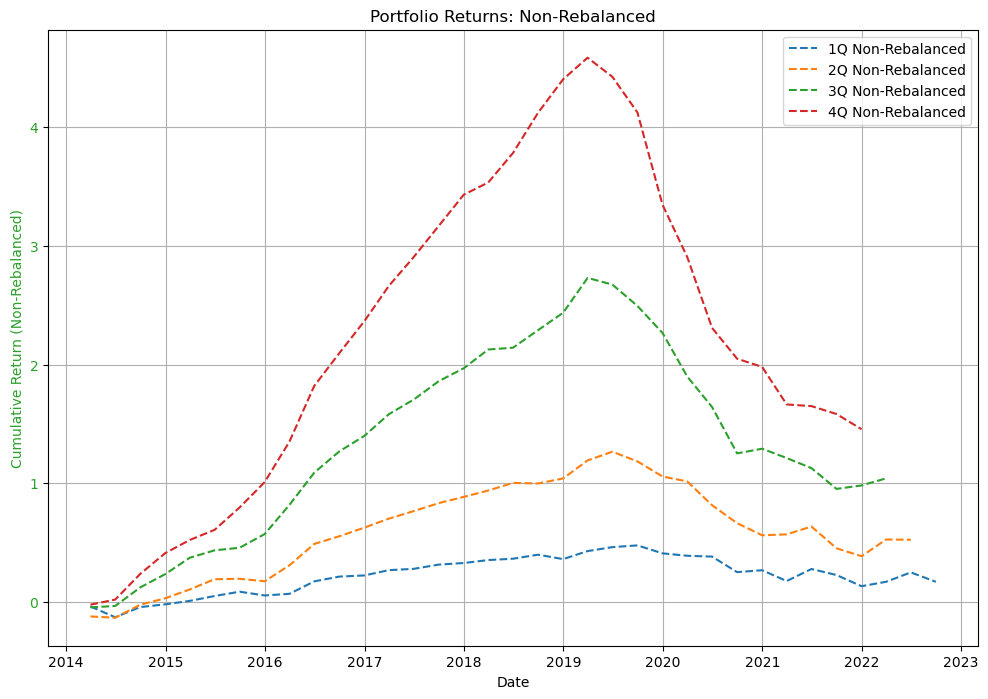

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/Users/rajeevmaharaj/Desktop/risk/RISK_Port.csv'
data = pd.read_csv(file_path)

# Convert the 'Date(quarter)' column to datetime format
data['Date'] = pd.to_datetime(data['Date(quarter)'], format='%d-%b-%y')

# Filter data to start from 2010
data = data[data['Date'] >= '2010-01-01']

# Sort data by date in ascending order
data = data.sort_values(by='Date').reset_index(drop=True)

# Fill missing values using forward fill method
data = data.fillna(method='ffill').fillna(method='bfill')

# Define the time intervals in quarters
time_intervals_quarters = {
    '1Q': 1,
    '2Q': 2,
    '3Q': 3,
    '4Q': 4
}

# List of tickers
tickers = ['CPI', 'KRI', 'Semiconductor', 'TLT', 'QQQ', 'SPY']

# Calculate quarterly forward returns for each ticker
for ticker in tickers:
    for interval_name, interval_quarters in time_intervals_quarters.items():
        data[f'{ticker}_{interval_name}_FWD_RET'] = data[ticker].pct_change(periods=interval_quarters).shift(-interval_quarters)

# Calculate portfolio returns for rebalanced and non-rebalanced scenarios
def calculate_portfolio_returns(data, tickers, interval_name, rebalance=True):
    returns = data[[f'{ticker}_{interval_name}_FWD_RET' for ticker in tickers]].mean(axis=1)
    if not rebalance:
        cumulative_returns = (1 + returns).cumprod() - 1
        return cumulative_returns  # Ensure cumulative returns start from 2010
    else:
        return returns.mean()

portfolio_returns_rebalanced = {}
portfolio_returns_non_rebalanced = {}

for interval_name in time_intervals_quarters.keys():
    portfolio_returns_rebalanced[interval_name] = calculate_portfolio_returns(data, tickers, interval_name, rebalance=True)
    portfolio_returns_non_rebalanced[interval_name] = calculate_portfolio_returns(data, tickers, interval_name, rebalance=False)

# Create a summary table with results
summary_table = pd.DataFrame({
    'Rebalanced': portfolio_returns_rebalanced,
    'Non-Rebalanced': portfolio_returns_non_rebalanced
})

# Plot the non-rebalanced cumulative returns separately
fig, ax2 = plt.subplots(figsize=(12, 8))

ax2.set_xlabel('Date')
ax2.set_ylabel('Cumulative Return (Non-Rebalanced)', color='tab:green')
for interval_name in time_intervals_quarters.keys():
    ax2.plot(data['Date'], portfolio_returns_non_rebalanced[interval_name], label=f'{interval_name} Non-Rebalanced', linestyle='--')
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.legend()
ax2.set_title('Portfolio Returns: Non-Rebalanced')
plt.grid(True)
plt.show()






In [26]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Load the uploaded CSV file
file_path = '/Users/rajeevmaharaj/Desktop/risk/RISK_Port.csv'
data = pd.read_csv(file_path)

# Convert the 'Date(quarter)' column to datetime format
data['Date'] = pd.to_datetime(data['Date(quarter)'], format='%d-%b-%y')

# Filter data to start from 2010
data = data[data['Date'] >= '2010-01-01']

# Sort data by date in ascending order
data = data.sort_values(by='Date').reset_index(drop=True)

# Fill missing values using forward fill method
data['SPY'] = data['SPY'].fillna(method='ffill')

# Convert relevant columns to numeric, if not already
columns_to_convert = [ 'KRI', 'Semiconductor', 'TLT', 'QQQ', 'SPY']
data[columns_to_convert] = data[columns_to_convert].apply(pd.to_numeric, errors='coerce')

# Calculate daily returns for SPY
data['SPY_Return'] = data['SPY'].pct_change()

# Identify the best and worst days
best_day = data['SPY_Return'].idxmax()
worst_day = data['SPY_Return'].idxmin()

# Prepare data for regression analysis
variables = ['KRI', 'Semiconductor', 'TLT', 'QQQ']
X = data[variables]

# Regression on the best day
y_best = data.loc[best_day, 'SPY']
X_best = sm.add_constant(X.loc[best_day:best_day])
model_best = sm.OLS([y_best], X_best).fit()

# Regression on the worst day
y_worst = data.loc[worst_day, 'SPY']
X_worst = sm.add_constant(X.loc[worst_day:worst_day])
model_worst = sm.OLS([y_worst], X_worst).fit()

# Print regression coefficients
print("Regression coefficients for the best day:")
print(model_best.params)

print("\nRegression coefficients for the worst day:")
print(model_worst.params)



Regression coefficients for the best day:
KRI              0.135654
Semiconductor    0.237884
TLT              0.593208
QQQ              0.778812
dtype: float64

Regression coefficients for the worst day:
KRI              0.123604
Semiconductor    0.222137
TLT              0.625679
QQQ              0.722127
dtype: float64


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Load the CSV file
file_path = '/Users/rajeevmaharaj/Desktop/risk/RISK_Port.csv'
data = pd.read_csv(file_path)

# Convert the 'Date(quarter)' column to datetime format
data['Date'] = pd.to_datetime(data['Date(quarter)'], format='%d-%b-%y')

# Filter data to start from 2010
data = data[data['Date'] >= '2010-01-01']

# Sort data by date in ascending order
data = data.sort_values(by='Date').reset_index(drop=True)

# Fill missing values using forward fill method
data['SPY'] = data['SPY'].fillna(method='ffill')

# Convert relevant columns to numeric
columns_to_convert = ['KRI', 'Semiconductor', 'TLT', 'QQQ', 'SPY']
data[columns_to_convert] = data[columns_to_convert].apply(pd.to_numeric, errors='coerce')

# Calculate daily returns for each asset
for col in columns_to_convert:
    data[f'{col}_Return'] = data[col].pct_change()

# Calculate cumulative returns for each asset
for col in columns_to_convert:
    data[f'{col}_Cumulative'] = (1 + data[f'{col}_Return']).cumprod()

# Assume initial equal weights for each asset
initial_weights = {col: 1/len(columns_to_convert) for col in columns_to_convert}

# Calculate portfolio value over time
data['Portfolio_Value'] = 0
for col in columns_to_convert:
    data['Portfolio_Value'] += initial_weights[col] * data[f'{col}_Cumulative']

# Calculate portfolio returns
data['Portfolio_Return'] = data['Portfolio_Value'].pct_change()

# Create a summary table with returns in percentage
returns_table = data[['Date'] + [f'{col}_Return' for col in columns_to_convert] + ['Portfolio_Return']].copy()
returns_table.columns = ['Date'] + [f'{col}_Return(%)' for col in columns_to_convert] + ['Portfolio_Return(%)']
returns_table = returns_table.dropna().reset_index(drop=True)
returns_table.iloc[:, 1:] = returns_table.iloc[:, 1:].round(4) * 100
# Display the summary table
print("Portfolio and Asset Returns Over Time:")
print(returns_table)


Portfolio and Asset Returns Over Time:
         Date  KRI_Return(%)  Semiconductor_Return(%)  TLT_Return(%)  \
0  2014-09-30         -31.40                   -11.24           6.22   
1  2014-12-31          17.00                    14.16           1.07   
2  2015-03-31           0.13                     5.46          -1.89   
3  2015-06-30           0.55                     8.35           0.21   
4  2015-09-30          -2.11                     8.78           4.31   
5  2015-12-31           2.85                     5.50          -5.15   
6  2016-03-31          -7.68                    -0.67           0.66   
7  2016-06-30          15.33                     0.43          -3.49   
8  2016-09-30          15.67                    19.24           1.55   
9  2016-12-31           9.14                     4.70          -1.43   
10 2017-03-31           4.66                     3.75          -3.63   
11 2017-06-30          18.19                     6.33          -5.84   
12 2017-09-30           3

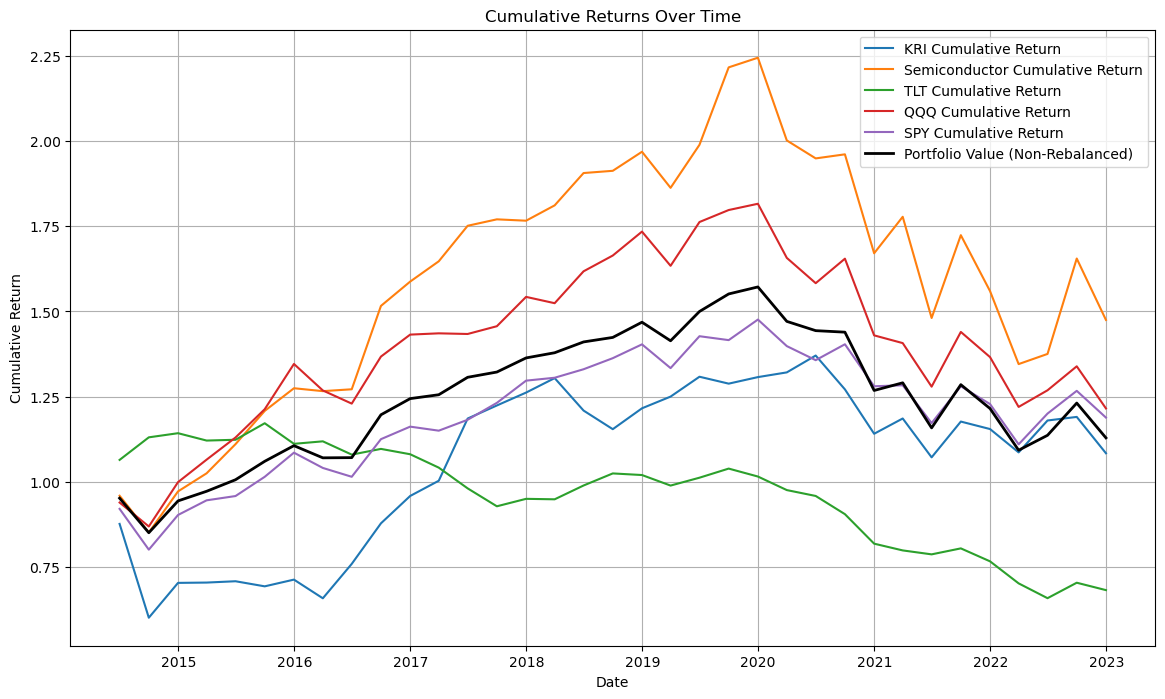

In [28]:
# Plot the cumulative returns of the portfolio and each asset
plt.figure(figsize=(14, 8))
for col in columns_to_convert:
    plt.plot(data['Date'], data[f'{col}_Cumulative'], label=f'{col} Cumulative Return')
plt.plot(data['Date'], data['Portfolio_Value'], label='Portfolio Value (Non-Rebalanced)', color='black', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.show()


In [29]:
# Regression analysis for the best and worst windows around SPY return
best_day = data['SPY_Return'].idxmax()
worst_day = data['SPY_Return'].idxmin()
window_size = 5

# Create windows around the best and worst days
best_window = data.loc[max(0, best_day-window_size):min(len(data)-1, best_day+window_size)]
worst_window = data.loc[max(0, worst_day-window_size):min(len(data)-1, worst_day+window_size)]

# Prepare data for regression analysis
variables = ['KRI', 'Semiconductor', 'TLT', 'QQQ']

# Regression on the best window
y_best = best_window['SPY']
X_best = sm.add_constant(best_window[variables])
model_best = sm.OLS(y_best, X_best).fit()

# Regression on the worst window
y_worst = worst_window['SPY']
X_worst = sm.add_constant(worst_window[variables])
model_worst = sm.OLS(y_worst, X_worst).fit()

# Print regression results
print("Regression results for the best window:")
print(model_best.summary())

print("\nRegression results for the worst window:")
print(model_worst.summary())

Regression results for the best window:
                            OLS Regression Results                            
Dep. Variable:                    SPY   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     135.8
Date:                Mon, 08 Jul 2024   Prob (F-statistic):           0.000160
Time:                        01:55:33   Log-Likelihood:                -19.830
No. Observations:                   9   AIC:                             49.66
Df Residuals:                       4   BIC:                             50.65
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const 

/Users/rajeevmaharaj/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/rajeevmaharaj/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
